In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [22]:
store_sales = pd.read_csv('store_sale.csv')
store_sales.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


In [23]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [24]:
store_sales = store_sales.drop(['store','item'], axis=1)

In [25]:
store_sales['date'] = pd.to_datetime(store_sales['date'])

In [26]:
store_sales['date'] = store_sales['date'].dt.to_period('M')
monthly_sales = store_sales.groupby('date').sum().reset_index()

In [27]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()
monthly_sales.head(10)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


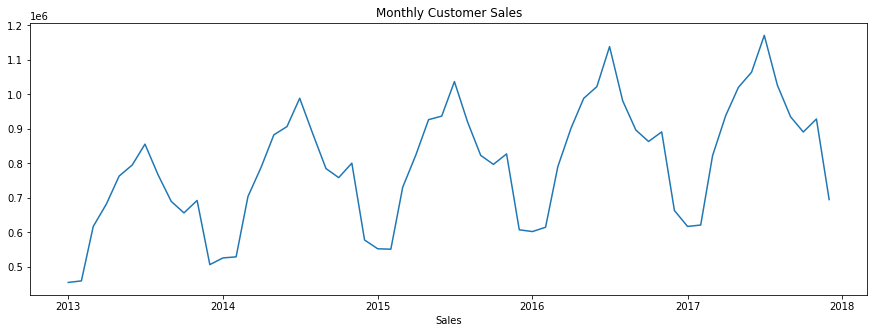

In [28]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel('Date')
plt.xlabel('Sales')
plt.title("Monthly Customer Sales")
plt.show()

In [29]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


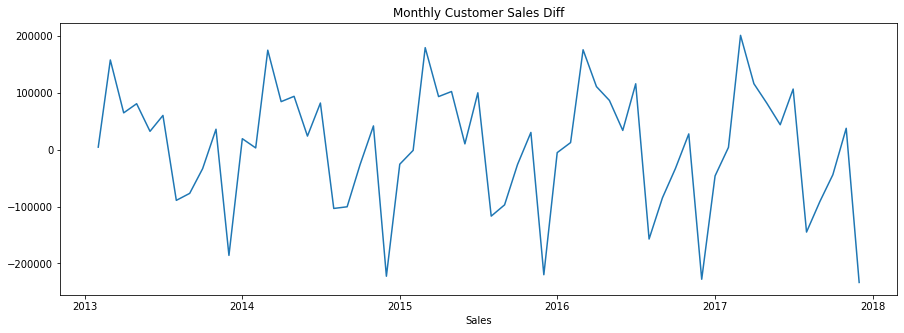

In [30]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales_diff'])
plt.xlabel('Date')
plt.xlabel('Sales')
plt.title("Monthly Customer Sales Diff")
plt.show()

In [31]:
supverised_data = monthly_sales.drop(['date','sales'], axis=1)

In [32]:
for i in range(1,13):
    col_name = 'month_' + str(i)
    supverised_data[col_name] = supverised_data['sales_diff'].shift(i)

In [33]:
supverised_data = supverised_data.dropna().reset_index(drop=True)
supverised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


In [34]:
train_data = supverised_data[:-12]
test_data = supverised_data[-12:]
print('Train Data Shape:', train_data.shape)
print('Test Data Shape:', test_data.shape)

Train Data Shape: (35, 13)
Test Data Shape: (12, 13)


In [35]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)

MinMaxScaler(feature_range=(-1, 1))

In [36]:
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [37]:
X_train, y_train = train_data[:,1:], train_data[:,0:1]
X_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print('X_test Shape:', X_test.shape)
print('y_test Shape:', y_test.shape)


X_train Shape: (35, 12)
y_train Shape: (35,)
X_test Shape: (12, 12)
y_test Shape: (12,)


In [38]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_14108\3984850881.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)


In [39]:
act_sales = monthly_sales['sales'][-13:].to_list()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_14108\2173393283.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  act_sales = monthly_sales['sales'][-13:].to_list()


#### Linear Regression

In [40]:
linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)
linreg_pred = linreg_model.predict(X_test)

In [41]:
linreg_pred = linreg_pred.reshape(-1,1)
linreg_pred_test_set = np.concatenate([linreg_pred,X_test], axis=1)
linreg_pred_test_set = scaler.inverse_transform(linreg_pred_test_set)

In [42]:
result_list = []
for index in range(0, len(linreg_pred_test_set)):
    result_list.append(linreg_pred_test_set[index][0] + act_sales[index])
linreg_pred_series = pd.Series(result_list,name='linreg_pred')
predict_df = predict_df.merge(linreg_pred_series, left_index=True, right_index=True)

In [43]:
linreg_rmse = np.sqrt(mean_squared_error(predict_df['linreg_pred'], monthly_sales['sales'][-12:]))
linreg_mae = mean_absolute_error(predict_df['linreg_pred'], monthly_sales['sales'][-12:])
linreg_r2 = r2_score(predict_df['linreg_pred'], monthly_sales['sales'][-12:])
print('Linear Regression RMSE: ', linreg_rmse)
print('Linear Regression MAE: ', linreg_mae)
print('Linear Regression R2 Score: ', linreg_r2)

Linear Regression RMSE:  16221.272385416896
Linear Regression MAE:  12433.184266490784
Linear Regression R2 Score:  0.9906152516380968


C:\Users\Administrator\AppData\Local\Temp\ipykernel_14108\3553433356.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  linreg_rmse = np.sqrt(mean_squared_error(predict_df['linreg_pred'], monthly_sales['sales'][-12:]))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_14108\3553433356.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  linreg_mae = mean_absolute_error(predict_df['linreg_pred'], monthly_sales['sales'][-12:])
C:\Users\Administrator\AppData\Local\Temp\ipykernel_1

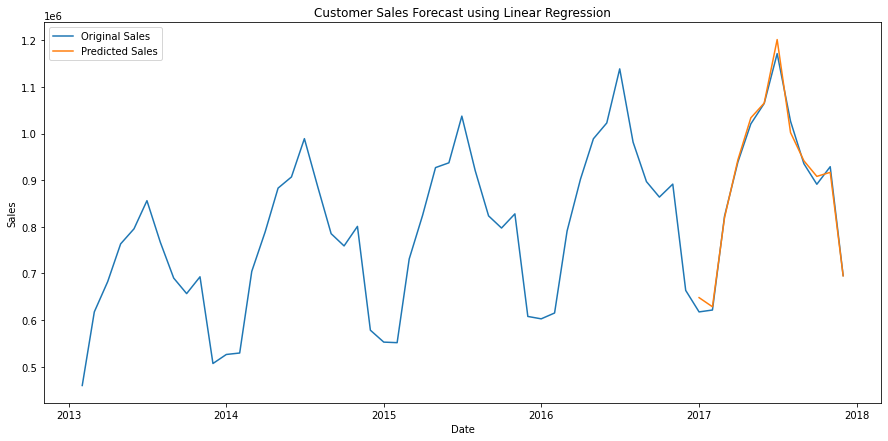

In [44]:
plt.figure(figsize=(15,7))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.plot(predict_df['date'], predict_df['linreg_pred'])
plt.title("Customer Sales Forecast using Linear Regression")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(["Original Sales", "Predicted Sales"])
plt.show()

#### Random Forest

In [45]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=20)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

In [46]:
rf_pred = rf_pred.reshape(-1,1)
rf_pred_test_set = np.concatenate([rf_pred,X_test], axis=1)
rf_pred_test_set = scaler.inverse_transform(rf_pred_test_set)

In [47]:
result_list = []
for index in range(0, len(rf_pred_test_set)):
    result_list.append(rf_pred_test_set[index][0] + act_sales[index])
rf_pred_series = pd.Series(result_list, name='rf_pred')
predict_df = predict_df.merge(rf_pred_series, left_index=True, right_index=True)

In [48]:
rf_rmse = np.sqrt(mean_squared_error(predict_df['rf_pred'], monthly_sales['sales'][-12:]))
rf_mae = mean_absolute_error(predict_df['rf_pred'], monthly_sales['sales'][-12:])
rf_r2 = r2_score(predict_df['rf_pred'], monthly_sales['sales'][-12:])
print('Random Forest RMSE: ', rf_rmse)
print('Random Forest MAE: ', rf_mae)
print('Random Forest R2 Score: ', rf_r2)

Random Forest RMSE:  17930.579942450513
Random Forest MAE:  15330.960833333354
Random Forest R2 Score:  0.9878031183022942


C:\Users\Administrator\AppData\Local\Temp\ipykernel_14108\335354226.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  rf_rmse = np.sqrt(mean_squared_error(predict_df['rf_pred'], monthly_sales['sales'][-12:]))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_14108\335354226.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  rf_mae = mean_absolute_error(predict_df['rf_pred'], monthly_sales['sales'][-12:])
C:\Users\Administrator\AppData\Local\Temp\ipykernel_14108\335354226.py:

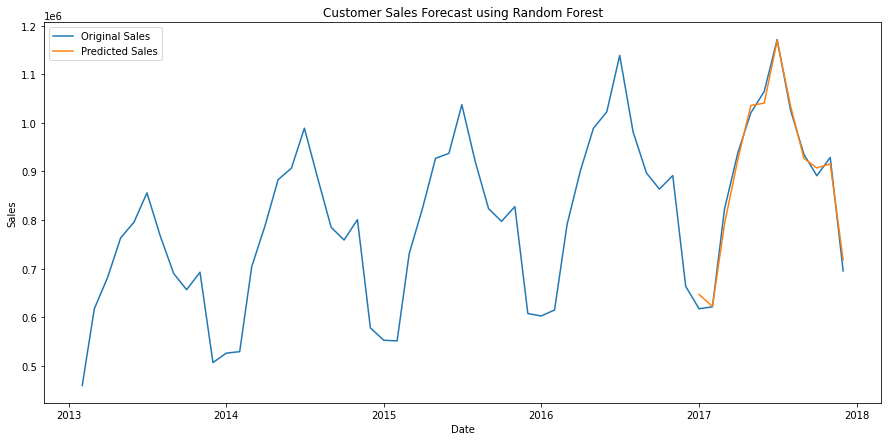

In [49]:
plt.figure(figsize=(15,7))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.plot(predict_df['date'], predict_df['rf_pred'])
plt.title("Customer Sales Forecast using Random Forest")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(["Original Sales", "Predicted Sales"])
plt.show()

#### XG Boost

In [50]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.2, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

In [51]:
xgb_pred = xgb_pred.reshape(-1,1)
xgb_pred_test_set = np.concatenate([xgb_pred,X_test], axis=1)
xgb_pred_test_set = scaler.inverse_transform(xgb_pred_test_set)

In [52]:
result_list = []
for index in range(0, len(xgb_pred_test_set)):
    result_list.append(xgb_pred_test_set[index][0] + act_sales[index])
xgb_pred_series = pd.Series(result_list, name='xgb_pred')
predict_df = predict_df.merge(xgb_pred_series, left_index=True, right_index=True)

In [53]:
xgb_rmse = np.sqrt(mean_squared_error(predict_df['xgb_pred'], monthly_sales['sales'][-12:]))
xgb_mae = mean_absolute_error(predict_df['xgb_pred'], monthly_sales['sales'][-12:])
xgb_r2 = r2_score(predict_df['xgb_pred'], monthly_sales['sales'][-12:])
print('XG Boost RMSE: ', xgb_rmse)
print('XG Boost MAE: ', xgb_mae)
print('XG Boost R2 Score: ', xgb_r2)

XG Boost RMSE:  15701.124706426719
XG Boost MAE:  13342.738751299059
XG Boost R2 Score:  0.9907513141349301


C:\Users\Administrator\AppData\Local\Temp\ipykernel_14108\353020178.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  xgb_rmse = np.sqrt(mean_squared_error(predict_df['xgb_pred'], monthly_sales['sales'][-12:]))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_14108\353020178.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  xgb_mae = mean_absolute_error(predict_df['xgb_pred'], monthly_sales['sales'][-12:])
C:\Users\Administrator\AppData\Local\Temp\ipykernel_14108\353020178

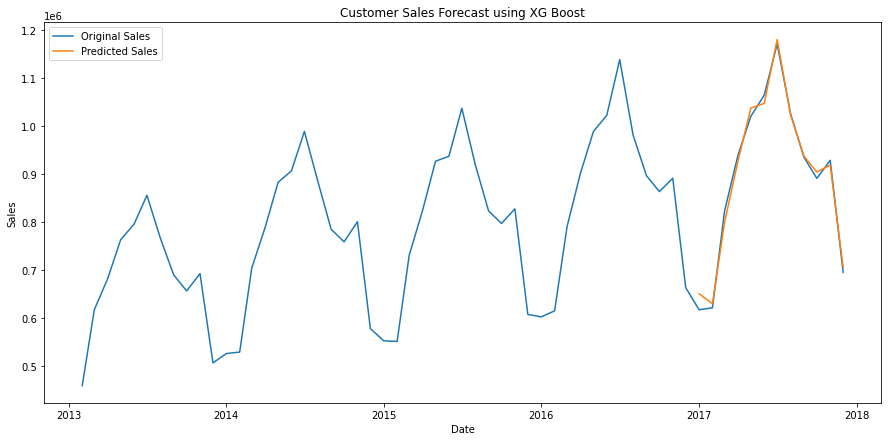

In [54]:
plt.figure(figsize=(15,7))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.plot(predict_df['date'], predict_df['xgb_pred'])
plt.title("Customer Sales Forecast using XG Boost")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(["Original Sales", "Predicted Sales"])
plt.show()

#### LSTM

In [55]:
X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [56]:
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train_lstm.shape[1], X_test_lstm.shape[2])))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [57]:
checkpoint_filepath = os.getcwd()
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)
callbacks = [EarlyStopping(patience=5), model_checkpoint_callback]

In [58]:
history = model.fit(X_train_lstm, y_train, epochs=200, batch_size=1, validation_data=(X_test_lstm, y_test), callbacks=callbacks)

Epoch 1/200
32/35 [==========================>...] - ETA: 0s - loss: 0.3148 

INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 140ms/step - loss: 0.2923 - val_loss: 0.3276
Epoch 2/200
31/35 [=========================>....] - ETA: 0s - loss: 0.2321    

INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 146ms/step - loss: 0.2719 - val_loss: 0.3086
Epoch 3/200
27/35 [======================>.......] - ETA: 0s - loss: 0.2875

INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


35/35 [==============================] - 4s 125ms/step - loss: 0.2542 - val_loss: 0.2865
Epoch 4/200
27/35 [======================>.......] - ETA: 0s - loss: 0.1547

INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


35/35 [==============================] - 4s 125ms/step - loss: 0.2348 - val_loss: 0.2673
Epoch 5/200
32/35 [==========================>...] - ETA: 0s - loss: 0.2296    

INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 139ms/step - loss: 0.2166 - val_loss: 0.2426
Epoch 6/200
33/35 [===========================>..] - ETA: 0s - loss: 0.1986

INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


35/35 [==============================] - 4s 120ms/step - loss: 0.1943 - val_loss: 0.2173
Epoch 7/200
32/35 [==========================>...] - ETA: 0s - loss: 0.1567

INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 135ms/step - loss: 0.1732 - val_loss: 0.1933
Epoch 8/200
32/35 [==========================>...] - ETA: 0s - loss: 0.1622

INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


35/35 [==============================] - 4s 121ms/step - loss: 0.1508 - val_loss: 0.1681
Epoch 9/200
32/35 [==========================>...] - ETA: 0s - loss: 0.1372

INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


35/35 [==============================] - 4s 121ms/step - loss: 0.1290 - val_loss: 0.1450
Epoch 10/200
27/35 [======================>.......] - ETA: 0s - loss: 0.1273    

INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 142ms/step - loss: 0.1100 - val_loss: 0.1251
Epoch 11/200
29/35 [=======================>......] - ETA: 0s - loss: 0.1051

INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


35/35 [==============================] - 4s 123ms/step - loss: 0.0950 - val_loss: 0.1084
Epoch 12/200
33/35 [===========================>..] - ETA: 0s - loss: 0.0876

INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 136ms/step - loss: 0.0834 - val_loss: 0.0943
Epoch 13/200
29/35 [=======================>......] - ETA: 0s - loss: 0.0818

INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


35/35 [==============================] - 4s 124ms/step - loss: 0.0722 - val_loss: 0.0835
Epoch 14/200
29/35 [=======================>......] - ETA: 0s - loss: 0.0561

INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


35/35 [==============================] - 4s 121ms/step - loss: 0.0633 - val_loss: 0.0749
Epoch 15/200
32/35 [==========================>...] - ETA: 0s - loss: 0.0598

INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 137ms/step - loss: 0.0555 - val_loss: 0.0646
Epoch 16/200
32/35 [==========================>...] - ETA: 0s - loss: 0.0525

INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


35/35 [==============================] - 4s 121ms/step - loss: 0.0482 - val_loss: 0.0565
Epoch 17/200
32/35 [==========================>...] - ETA: 0s - loss: 0.0451

INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


35/35 [==============================] - 4s 121ms/step - loss: 0.0423 - val_loss: 0.0481
Epoch 18/200
35/35 [==============================] - ETA: 0s - loss: 0.0360

INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


35/35 [==============================] - 4s 131ms/step - loss: 0.0360 - val_loss: 0.0426
Epoch 19/200
34/35 [============================>.] - ETA: 0s - loss: 0.0316    

INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


35/35 [==============================] - 4s 123ms/step - loss: 0.0309 - val_loss: 0.0359
Epoch 20/200
29/35 [=======================>......] - ETA: 0s - loss: 0.0267    

INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 134ms/step - loss: 0.0261 - val_loss: 0.0297
Epoch 21/200
29/35 [=======================>......] - ETA: 0s - loss: 0.0263

INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


35/35 [==============================] - 4s 124ms/step - loss: 0.0221 - val_loss: 0.0253
Epoch 22/200
31/35 [=========================>....] - ETA: 0s - loss: 0.0191    

INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


35/35 [==============================] - 4s 119ms/step - loss: 0.0184 - val_loss: 0.0214
Epoch 23/200
31/35 [=========================>....] - ETA: 0s - loss: 0.0166    

INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 135ms/step - loss: 0.0148 - val_loss: 0.0179
Epoch 24/200
18/35 [==============>...............] - ETA: 0s - loss: 0.0189

INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


35/35 [==============================] - 4s 118ms/step - loss: 0.0119 - val_loss: 0.0156
Epoch 25/200
32/35 [==========================>...] - ETA: 0s - loss: 0.0103    

INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


35/35 [==============================] - 4s 128ms/step - loss: 0.0097 - val_loss: 0.0135
Epoch 26/200
29/35 [=======================>......] - ETA: 0s - loss: 0.0090    

INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


35/35 [==============================] - 4s 118ms/step - loss: 0.0078 - val_loss: 0.0120
Epoch 27/200
32/35 [==========================>...] - ETA: 0s - loss: 0.0066

INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


35/35 [==============================] - 4s 118ms/step - loss: 0.0065 - val_loss: 0.0109
Epoch 28/200
32/35 [==========================>...] - ETA: 0s - loss: 0.0059    

INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 134ms/step - loss: 0.0054 - val_loss: 0.0102
Epoch 29/200
29/35 [=======================>......] - ETA: 0s - loss: 0.0046

INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


35/35 [==============================] - 4s 120ms/step - loss: 0.0047 - val_loss: 0.0095
Epoch 30/200
35/35 [==============================] - ETA: 0s - loss: 0.0041

INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 137ms/step - loss: 0.0041 - val_loss: 0.0092
Epoch 31/200
27/35 [======================>.......] - ETA: 0s - loss: 0.0036

INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


35/35 [==============================] - 4s 122ms/step - loss: 0.0037 - val_loss: 0.0088
Epoch 32/200
29/35 [=======================>......] - ETA: 0s - loss: 0.0031

INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


35/35 [==============================] - 4s 117ms/step - loss: 0.0035 - val_loss: 0.0088
Epoch 33/200
35/35 [==============================] - ETA: 0s - loss: 0.0031

INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 139ms/step - loss: 0.0031 - val_loss: 0.0084
Epoch 34/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0084
Epoch 35/200
31/35 [=========================>....] - ETA: 0s - loss: 0.0029

INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


35/35 [==============================] - 4s 128ms/step - loss: 0.0028 - val_loss: 0.0083
Epoch 36/200
32/35 [==========================>...] - ETA: 0s - loss: 0.0027    

INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


35/35 [==============================] - 4s 120ms/step - loss: 0.0026 - val_loss: 0.0082
Epoch 37/200
31/35 [=========================>....] - ETA: 0s - loss: 0.0026    

INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 134ms/step - loss: 0.0025 - val_loss: 0.0081
Epoch 38/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0084
Epoch 39/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0085
Epoch 40/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0084
Epoch 41/200
30/35 [========================>.....] - ETA: 0s - loss: 0.0023    

INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: c:\Users\Administrator\Desktop\datascience\customer_sales_prediction\assets


35/35 [==============================] - 4s 120ms/step - loss: 0.0024 - val_loss: 0.0081
Epoch 42/200
35/35 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0084
Epoch 43/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0085
Epoch 44/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0087
Epoch 45/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0088
Epoch 46/200
35/35 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0082


In [59]:
metrics_df = pd.DataFrame(history.history)
print(metrics_df)

        loss  val_loss
0   0.292292  0.327590
1   0.271852  0.308641
2   0.254158  0.286464
3   0.234816  0.267327
4   0.216584  0.242554
5   0.194323  0.217349
6   0.173200  0.193347
7   0.150776  0.168128
8   0.129037  0.145026
9   0.110037  0.125133
10  0.095045  0.108375
11  0.083418  0.094299
12  0.072214  0.083453
13  0.063343  0.074907
14  0.055512  0.064642
15  0.048233  0.056461
16  0.042314  0.048128
17  0.035975  0.042644
18  0.030865  0.035896
19  0.026072  0.029729
20  0.022060  0.025264
21  0.018366  0.021382
22  0.014807  0.017922
23  0.011942  0.015568
24  0.009719  0.013536
25  0.007794  0.012012
26  0.006531  0.010929
27  0.005450  0.010157
28  0.004656  0.009482
29  0.004097  0.009214
30  0.003650  0.008831
31  0.003472  0.008814
32  0.003079  0.008381
33  0.002938  0.008418
34  0.002788  0.008329
35  0.002639  0.008249
36  0.002501  0.008107
37  0.002507  0.008380
38  0.002416  0.008480
39  0.002362  0.008448
40  0.002351  0.008086
41  0.002225  0.008388
42  0.00224

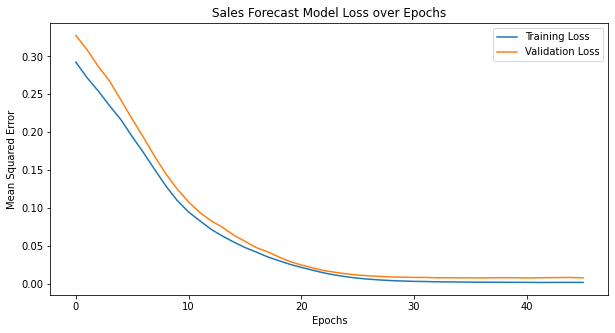

In [60]:
plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.loss)
plt.plot(metrics_df.index, metrics_df.val_loss)
plt.title('Sales Forecast Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

In [61]:
lstm_pred = model.predict(X_test_lstm, batch_size=1)

12/12 [==============================] - 0s 1ms/step


In [62]:
lstm_pred = lstm_pred.reshape(-1,1)
lstm_pred_test_set = np.concatenate([lstm_pred,X_test], axis=1)
lstm_pred_test_set = scaler.inverse_transform(lstm_pred_test_set)

In [63]:
result_list = []
for index in range(0, len(lstm_pred_test_set)):
    result_list.append(lstm_pred_test_set[index][0] + act_sales[index])
lstm_pred_series = pd.Series(result_list, name='lstm_pred')
predict_df = predict_df.merge(lstm_pred_series, left_index=True, right_index=True)

In [64]:
lstm_rmse = np.sqrt(mean_squared_error(predict_df['lstm_pred'], monthly_sales['sales'][-12:]))
lstm_mae = mean_absolute_error(predict_df['lstm_pred'], monthly_sales['sales'][-12:])
lstm_r2 = r2_score(predict_df['lstm_pred'], monthly_sales['sales'][-12:])
print('LSTM RMSE: ', lstm_rmse)
print('LSTM MAE: ', lstm_mae)
print('LSTM R2 Score: ', lstm_r2)

LSTM RMSE:  18512.341134523933
LSTM MAE:  15184.510503380248
LSTM R2 Score:  0.987503822337064


C:\Users\Administrator\AppData\Local\Temp\ipykernel_14108\3529379307.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  lstm_rmse = np.sqrt(mean_squared_error(predict_df['lstm_pred'], monthly_sales['sales'][-12:]))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_14108\3529379307.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  lstm_mae = mean_absolute_error(predict_df['lstm_pred'], monthly_sales['sales'][-12:])
C:\Users\Administrator\AppData\Local\Temp\ipykernel_14108\352

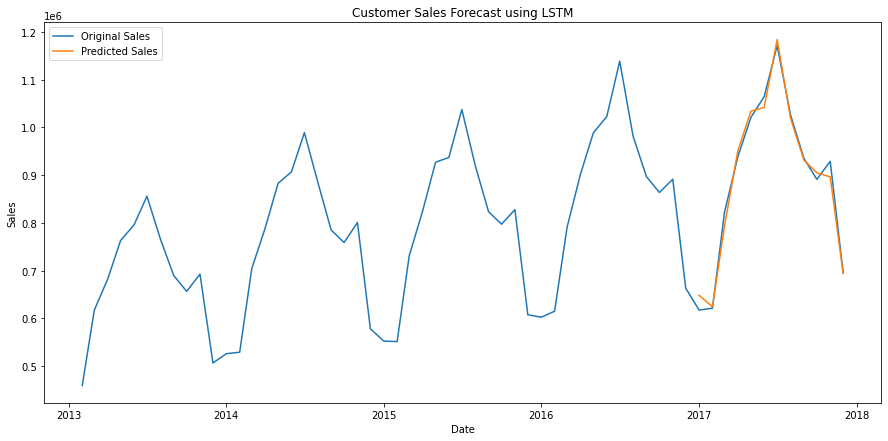

In [65]:
plt.figure(figsize=(15,7))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.plot(predict_df['date'], predict_df['lstm_pred'])
plt.title("Customer Sales Forecast using LSTM")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(["Original Sales", "Predicted Sales"])
plt.show()

#### Comparing Linear Regression, Random Forest, XG Boost, LSTM

In [66]:
linreg_stats = [linreg_rmse, linreg_mae, linreg_r2]
rf_stats = [rf_rmse, rf_mae, rf_r2]
xgb_stats = [xgb_rmse, xgb_mae, xgb_r2]
lstm_stats = [lstm_rmse, lstm_mae, lstm_r2]

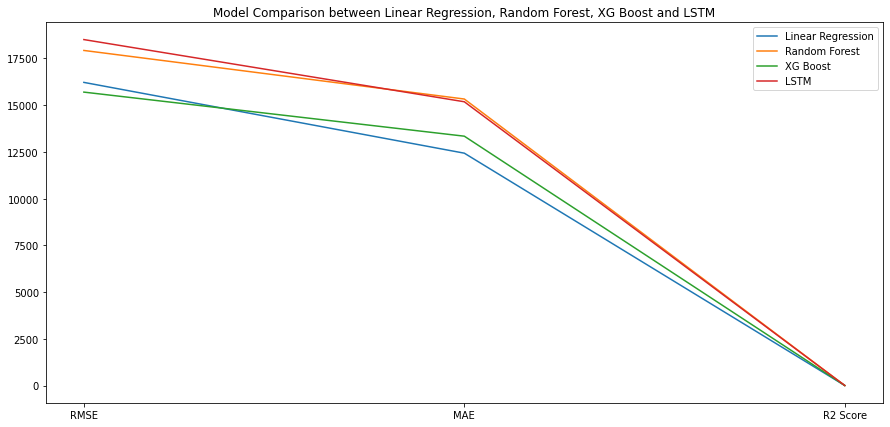

In [67]:
plt.figure(figsize=(15,7))
plt.plot(linreg_stats)
plt.plot(rf_stats)
plt.plot(xgb_stats)
plt.plot(lstm_stats)
plt.title("Model Comparison between Linear Regression, Random Forest, XG Boost and LSTM")
plt.xticks([0,1,2], labels=['RMSE','MAE','R2 Score'])
plt.legend(["Linear Regression", "Random Forest", "XG Boost", "LSTM"])
plt.show()